## Imports

In [2]:
from tinygrad import nn, Tensor, TinyJit
from tinygrad.nn.datasets import mnist
from IPython.display import display
import numpy as np
from PIL import Image

X_train, Y_train, X_test, Y_test = mnist()
X_train, Y_train, X_test, Y_test = X_train/255.0, Y_train, X_test/255.0, Y_test
X_pred = X_test.reshape(X_test.shape[0], 784)

## Model

In [3]:
latent_size = 9

class Encoder:
    def __init__(self):
        self.l1 = nn.Linear(784, 128)
        self.b1 = nn.BatchNorm(128)
        self.l2 = nn.Linear(128, latent_size)
        self.b2 = nn.BatchNorm(latent_size)
        self.l3 = nn.Linear(latent_size, latent_size)
        
    def __call__(self, x:Tensor) -> Tensor:
        x = self.l1(x).relu()
        x = self.l2(self.b1(x)).relu()
        return self.l3(self.b2(x)).sigmoid()

class Decoder:
    def __init__(self):
        self.l1 = nn.Linear(latent_size, latent_size)
        self.b1 = nn.BatchNorm(latent_size)
        self.l2 = nn.Linear(latent_size, 128)
        self.b2 = nn.BatchNorm(128)
        self.l3 = nn.Linear(128, 784)
        
    def __call__(self, x:Tensor) -> Tensor:
        x = self.l1(x).relu()
        x = self.l2(self.b1(x)).relu()
        return self.l3(self.b2(x)).sigmoid()
    
class Model:
    def __init__(self, enco, deco):
        self.encoder = enco
        self.decoder = deco
        
    def __call__(self, x:Tensor) -> Tensor:
        latent = self.encoder(x)
        final = self.decoder(latent)
        return final

encoder = Encoder()
decoder = Decoder()
model = Model(encoder, decoder)

## Train

In [4]:
optim = nn.optim.Adam(nn.state.get_parameters(model))
batch_size = 256

@TinyJit
@Tensor.train()
def train_step() -> Tensor:
    Tensor.training = True
    samples = Tensor.randint(batch_size, high=X_train.shape[0])
    X = X_train[samples]
    X = X.reshape(batch_size, 784)
    optim.zero_grad()
    loss = model(X).binary_crossentropy(X).backward()
    optim.step()
    return loss

for step in range(1000):
    loss = train_step()
    Tensor.training = False
    if step%100 == 0:
        print(f"step {step:4d}, loss {loss.item():.2f}")

step    0, loss 0.73
step  100, loss 0.33
step  200, loss 0.19
step  300, loss 0.16
step  400, loss 0.16
step  500, loss 0.15
step  600, loss 0.15
step  700, loss 0.15
step  800, loss 0.14
step  900, loss 0.14


## GRID VID

In [5]:
from tinygrad.helpers import trange

@TinyJit
@Tensor.test()
def get_frame(frameNum, i, j, tiles, predsIdx) -> Tensor:
    #this_latent_space = latent_grid[predsIdx][0] + frameNum * latent_grid[predsIdx][1]
    this_diff = latent_grid[predsIdx][1].mul(frameNum)
    this_latent_space = latent_grid[predsIdx][0].add(this_diff)
    this_img = decoder(this_latent_space.reshape(1, 9))
    return this_img.realize()

@Tensor.test()
def fwd(this_latent_space:Tensor) -> Tensor:
    Tensor.training = False
    Tensor.no_grad = True
    this_latent_space.realize()
    return decoder(this_latent_space.reshape(1, 9))

fwd_jitted = TinyJit(fwd)

encoder_preds = encoder(X_test.reshape(10000, 784))

totalFrames = 100
tiles = 10

# Grid of Latent Spaces and Diffs
latent_grid = []
for i in range(tiles):
    for j in range(tiles):
        predsIdx = i * tiles + j
        this_latent_space = encoder_preds[predsIdx]
        next_latent_space = encoder_preds[predsIdx + 1]
        this_diff = (next_latent_space - this_latent_space) / totalFrames
        latent_grid.append([this_latent_space, this_diff])

blends = np.zeros(shape=(totalFrames, 28 * tiles, 28 * tiles, 1)).astype(np.uint8)
for frameNum in (t:=trange(totalFrames)):
    if frameNum == 0:
        continue
    for i in range(tiles):
        for j in range(tiles):
            predsIdx = i * tiles + j
            #this_latent_space = latent_grid[predsIdx][0] + frameNum * latent_grid[predsIdx][1]
            this_diff = latent_grid[predsIdx][1].mul(frameNum)
            this_latent_space = latent_grid[predsIdx][0].add(this_diff)
            #print(this_latent_space)
            #this_img = decoder(this_latent_space.reshape(1, 9))
            this_img = fwd_jitted(this_latent_space)
            #this_img = decoder(this_latent_space.reshape(1, 9))
            #this_img = get_frame(frameNum, i, j, tiles, predsIdx)
            this_img = this_img.numpy()*255
            this_img = this_img.astype(np.uint8)
            blends[frameNum, i*28:(i+1)*28, j*28:(j+1)*28] = this_img.reshape(28, 28, 1)
    t.set_description(f"frame {frameNum}")

frame 99: 100%|███████████████████████████████| 100/100 [14:06<00:00,  0.12it/s]


In [23]:
import cv2

colored_frames = []
for frame in blends:
    colored_frames.append(cv2.applyColorMap(frame, cv2.COLORMAP_VIRIDIS))

colored_frames = np.array(colored_frames)

ims = [Image.fromarray(colored_frames[i].reshape(280, 280, 3)) for i in range(99)]

ims[0].save('unsorted_grid.gif', save_all=True, append_images=ims[1:], loop=0, duration=50)

## MP4

In [24]:
output = 'grid_blend.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output, fourcc, 30, (tiles*28, tiles*28))
            
for i, blend in enumerate(blends):
    if i % 10 == 0:
        print(i)
    out.write(cv2.applyColorMap(cv2.cvtColor(blend, cv2.COLOR_GRAY2RGB), cv2.COLORMAP_VIRIDIS))
            
out.release()

0
10
20
30
40
50
60
70
80
90


In [17]:
# 0 - 183
# 1 - 37
# 2 - 147
# 3 - 51
# 4 - 48
# 5 - 165
# 6 - 131
# 7 - 64
# 8 - 495
# 9 - 16

## Sorted Grid Vid

In [26]:
totalFrames = 100
tiles = 10

theIndexes = [183, 37, 147, 51, 48, 165, 131, 64, 495, 16]

encoder_preds = encoder(X_test.reshape(10000, 784))

the_latent_spaces = []
for idx in theIndexes:
    this_latent_space = encoder_preds[idx]
    the_latent_spaces.append(this_latent_space)

# Grid of Latent Spaces and Diffs
latent_grid = []
for i in range(tiles):
    for j in range(tiles):
        this_latent_space = the_latent_spaces[i]
        next_latent_space = the_latent_spaces[j]
        this_diff = (next_latent_space - this_latent_space) / totalFrames
        latent_grid.append([this_latent_space, this_diff])

blends = np.zeros(shape=(totalFrames, 28 * tiles, 28 * tiles, 1)).astype(np.uint8)
for frameNum in (t:=trange(totalFrames)):
    if frameNum == 0:
        continue
    for i in range(tiles):
        for j in range(tiles):
            predsIdx = i * tiles + j
            #this_latent_space = latent_grid[predsIdx][0] + frameNum * latent_grid[predsIdx][1]
            this_diff = latent_grid[predsIdx][1].mul(frameNum)
            this_latent_space = latent_grid[predsIdx][0].add(this_diff)
            #this_img = decoder(this_latent_space.reshape(1, 49))[0].numpy()
            this_img = fwd_jitted(this_latent_space)
            this_img = this_img.numpy()*255
            this_img = this_img.astype(np.uint8)
            #blends[frameNum, i*28:(i+1)*28, j*28:(j+1)*28] = this_img
            blends[frameNum, i*28:(i+1)*28, j*28:(j+1)*28] = this_img.reshape(28, 28, 1)
    t.set_description(f"frame {frameNum}")

frame 99: 100%|███████████████████████████████| 100/100 [26:51<00:00,  0.06it/s]


from


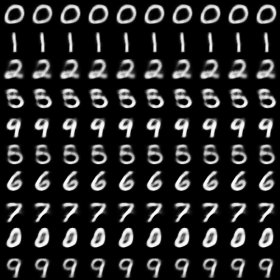

to


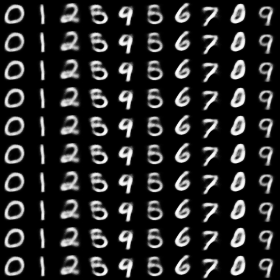

Unfortunately the 8 is garbage


In [36]:
print('from')
img1 = Image.fromarray(blends[2].reshape(280, 280))

display(img1)

print('to')

img2 = Image.fromarray(blends[98].reshape(280, 280))

display(img2)

print('Unfortunately the 8 is garbage')

In [29]:
colored_frames2 = []
for frame in blends:
    colored_frames2.append(cv2.applyColorMap(frame, cv2.COLORMAP_VIRIDIS))

colored_frames2 = np.array(colored_frames2)

ims = [Image.fromarray(colored_frames2[i].reshape(280, 280, 3)) for i in range(99)]

ims[0].save('sorted_grid.gif', save_all=True, append_images=ims[1:], loop=0, duration=50)

In [30]:
output = 'sorted_grid_blend.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output, fourcc, 30, (tiles*28, tiles*28))
            
for i, blend in enumerate(blends):
    if i % 10 == 0:
        print(i)
    out.write(cv2.applyColorMap(cv2.cvtColor(blend, cv2.COLOR_GRAY2RGB), cv2.COLORMAP_VIRIDIS))
            
out.release()

0
10
20
30
40
50
60
70
80
90
